# Chapter 14: The Zen of Testing

Paolo Perrotta, Programming Machine Learning: From Coding to Deep Learning (2020)

## The Threat of Overfitting

In [1]:
# The MNIST data loader that we used so far.
# It includes a training and a test set, but no validation set.

import numpy as np
import gzip
import struct


def load_images(filename):
    # Open and unzip the file of images:
    with gzip.open(filename, 'rb') as f:
        # Read the header information into a bunch of variables:
        _ignored, n_images, columns, rows = struct.unpack('>IIII', f.read(16))
        # Read all the pixels into a NumPy array:
        all_pixels = np.frombuffer(f.read(), dtype=np.uint8)
        # Reshape the pixels into a matrix where each line is an image:
        return all_pixels.reshape(n_images, columns * rows)
    
    
def standardize(training_set, test_set):
    average = np.average(training_set)
    standard_deviation = np.std(training_set)
    training_set_standardized = (training_set - average) / standard_deviation
    test_set_standardized = (test_set - average) / standard_deviation
    return (training_set_standardized, test_set_standardized)


# 60000 images, each 785 elements (1 bias + 28 * 28 pixels)
X_train = load_images("./mnist/train-images-idx3-ubyte.gz") #注意檔案路徑是否正確

# 10000 images, each 785 elements, with the same structure as X_train
X_test_all = load_images("./mnist/t10k-images-idx3-ubyte.gz") #注意檔案路徑是否正確

X_train, X_test_all = standardize(X_train, X_test_all)
X_validation, X_test = np.split(X_test_all, 2)

def load_labels(filename):
    # Open and unzip the file of images:
    with gzip.open(filename, 'rb') as f:
        # Skip the header bytes:
        f.read(8)
        # Read all the labels into a list:
        all_labels = f.read()
        # Reshape the list of labels into a one-column matrix:
        return np.frombuffer(all_labels, dtype=np.uint8).reshape(-1, 1)


def one_hot_encode(Y):
    n_labels = Y.shape[0]
    n_classes = 10
    encoded_Y = np.zeros((n_labels, n_classes))
    for i in range(n_labels):
        label = Y[i]
        encoded_Y[i][label] = 1
    return encoded_Y


# 60K labels, each a single digit from 0 to 9
Y_train_unencoded = load_labels("./mnist/train-labels-idx1-ubyte.gz") #注意檔案路徑是否正確

# 60K labels, each consisting of 10 one-hot encoded elements
Y_train = one_hot_encode(Y_train_unencoded)

# 10000 labels, each a single digit from 0 to 9
Y_test_all = load_labels("./mnist/t10k-labels-idx1-ubyte.gz") #注意檔案路徑是否正確
Y_validation, Y_test = np.split(Y_test_all, 2)

In [2]:
print(X_train.shape)

(60000, 784)


In [3]:
# The neural network, with the train() function hacked to provide
# histories of the loss and the accuracy on both the training set
# and the test set.


def sigmoid(z):
    return 1 / (1 + np.exp(-z))


def ReLU(x):
    return np.maximum(0, x)


def softmax(logits):
    exponentials = np.exp(logits)
    return exponentials / np.sum(exponentials, axis=1).reshape(-1, 1)


def sigmoid_gradient(sigmoid):
    return np.multiply(sigmoid, (1 - sigmoid))


def prepend_bias(X):
    return np.insert(X, 0, 1, axis=1)


def Dropout(y, ratio):
    yd = np.zeros(y.size)    
    num = round(y.size*(1-ratio))
    idx = np.random.choice(y.size, num, replace=False)
    yd[idx] = 1.0 / (1.0 - ratio)
    yd=np.reshape(yd,(y.shape))   
    return yd


def prepare_batches(X_train, Y_train, batch_size):
    x_batches = []
    y_batches = []
    n_examples = X_train.shape[0]
    for batch in range(0, n_examples, batch_size):
        batch_end = batch + batch_size
        x_batches.append(X_train[batch:batch_end])
        y_batches.append(Y_train[batch:batch_end])
    return x_batches, y_batches


def initialize_weights(n_input_variables, n_hidden_nodes, n_classes):
    np.random.seed(1234)

    w1_rows = n_input_variables + 1
    w1 = np.random.randn(w1_rows, n_hidden_nodes) * np.sqrt(1 / w1_rows)

    w2_rows = n_hidden_nodes + 1
    w2 = np.random.randn(w2_rows, n_classes) * np.sqrt(1 / w2_rows)
    return (w1, w2)


def forward(X, w1, w2):
    a  = np.matmul(prepend_bias(X), w1)     # (5 x 26) x (26 x 20) = 5 x 20
    h1 = ReLU(a)                         # 5 x 20
    h1 = h1 * Dropout(h1, 0.2)
    b  = np.matmul(prepend_bias(h1), w2)    # (5 x 21) x (21 x 20) = 5 x 20
    y_hat = softmax(b)
    return y_hat, h1

In [4]:
def back(X, Y, y_hat, w2, h1):
    dw2 = np.matmul(prepend_bias(h1).T, y_hat-Y)/X.shape[0]
    dh1 = np.matmul(y_hat - Y, w2[1:].T)
    da  = dh1 * (h1 > 0)
    dw1 = np.matmul(prepend_bias(X).T, da)/X.shape[0]
    return dw1, dw2


def classify(X, w1, w2):
    y_hat, _ = forward(X, w1, w2)
    labels = np.argmax(y_hat, axis=1)
    return labels.reshape(-1, 1)


def accuracy(X, Y_unencoded, w1, w2):
    return np.average(classify(X, w1, w2) == Y_unencoded) * 100.0


# This loss() takes different parameters than the ones in other source files
def loss(Y, y_hat):
    return -np.sum(Y * np.log(y_hat)) / Y.shape[0]


def report(epoch, batch, X_train, Y_train, X_test, Y_test, w1, w2):
    y_hat, _ = forward(X_train, w1, w2)
    training_loss = loss(Y_train, y_hat)
    classifications = classify(X_test, w1, w2)
    accuracy = np.average(classifications == Y_test) * 100.0
    if batch % 60 == 0:
        print("%5d-%d > Loss: %.8f, Accuracy: %.2f%%" %(epoch, batch, training_loss, accuracy))


def train(X_train, Y_train, X_test, Y_test, n_hidden_nodes, epochs, batch_size, lr):
    n_input_variables = X_train.shape[1]
    n_classes = Y_train.shape[1]

    w1, w2 = initialize_weights(n_input_variables, n_hidden_nodes, n_classes)
    x_batches, y_batches = prepare_batches(X_train, Y_train, batch_size)
    for epoch in range(epochs):
        for batch in range(len(x_batches)):
            y_hat, h = forward(x_batches[batch], w1, w2)
            w1_gradient, w2_gradient = back(x_batches[batch], y_batches[batch], y_hat, w2, h)
            w1 = w1 - (w1_gradient * lr)
            w2 = w2 - (w2_gradient * lr)
            report(epoch, batch, X_train, Y_train, X_test, Y_test, w1, w2)
    return (w1, w2)

In [5]:
print("Standardized MNIST:")
train(X_train, Y_train, X_validation, Y_validation,
      n_hidden_nodes=200, epochs=2, batch_size=60, lr=0.1)

Standardized MNIST:
    0-0 > Loss: 2.08440251, Accuracy: 28.44%
    0-60 > Loss: 0.44248985, Accuracy: 83.82%
    0-120 > Loss: 0.39171326, Accuracy: 84.90%
    0-180 > Loss: 0.31500638, Accuracy: 88.40%
    0-240 > Loss: 0.28034336, Accuracy: 89.10%
    0-300 > Loss: 0.27144628, Accuracy: 89.88%
    0-360 > Loss: 0.23936121, Accuracy: 91.46%
    0-420 > Loss: 0.23229536, Accuracy: 91.78%
    0-480 > Loss: 0.20986498, Accuracy: 91.72%
    0-540 > Loss: 0.20664141, Accuracy: 92.20%
    0-600 > Loss: 0.21186788, Accuracy: 91.78%
    0-660 > Loss: 0.19223205, Accuracy: 92.70%
    0-720 > Loss: 0.18271090, Accuracy: 93.12%
    0-780 > Loss: 0.17871003, Accuracy: 92.70%
    0-840 > Loss: 0.16571174, Accuracy: 93.38%
    0-900 > Loss: 0.16477460, Accuracy: 93.10%
    0-960 > Loss: 0.15113384, Accuracy: 93.94%
    1-0 > Loss: 0.15579689, Accuracy: 92.94%
    1-60 > Loss: 0.14841080, Accuracy: 93.64%
    1-120 > Loss: 0.14019266, Accuracy: 94.06%
    1-180 > Loss: 0.13382716, Accuracy: 94.18%

(array([[ 0.01656005, -0.04757347,  0.04634251, ...,  0.03422904,
          0.00627647, -0.03395554],
        [-0.01129275, -0.01998026,  0.0076361 , ..., -0.0377311 ,
         -0.00680341,  0.06744612],
        [-0.00797597, -0.03082469,  0.01473302, ..., -0.03874583,
          0.03815689,  0.05950397],
        ...,
        [-0.01988907,  0.00693261, -0.00274444, ...,  0.02329905,
          0.01321157,  0.03875862],
        [-0.07677853,  0.04489707,  0.04489876, ..., -0.01096247,
          0.01844856,  0.07025471],
        [ 0.0080454 ,  0.01973791,  0.03114444, ..., -0.02083924,
          0.01669538,  0.03356853]]),
 array([[-0.10068473, -0.0434787 , -0.06810641, ...,  0.00428759,
          0.15536482,  0.01917408],
        [-0.14225073,  0.12067803, -0.02355241, ...,  0.07584492,
         -0.10461501, -0.22598654],
        [-0.0566476 ,  0.06918854,  0.25291452, ..., -0.04456618,
         -0.16009462, -0.08965439],
        ...,
        [-0.00083683, -0.08498538, -0.02461143, ..., -

In [6]:
import time
from matplotlib import pyplot as plt
import seaborn as sns

def train(X_train, Y_train, X_validation, Y_validation,
          n_hidden_nodes, lr, batch_size, time_in_seconds):
    n_input_variables = X_train.shape[1]
    n_classes = Y_train.shape[1]

    w1, w2 = initialize_weights(n_input_variables, n_hidden_nodes, n_classes)
    x_batches, y_batches = prepare_batches(X_train, Y_train, batch_size)

    start_time = time.time()
    times = []
    losses = []
    epochs = 0
    steps = 0
    while True:
        batch = 0
        while (batch < len(x_batches)):
            training_classifications, _ = forward(X_train, w1, w2)
            training_loss = loss(Y_train, training_classifications)
            times.append(np.floor(time.time() - start_time))
            losses.append(training_loss)

            time_passed = time.time() - start_time
            if time_passed > time_in_seconds:
                return (times, losses, epochs, steps)

            y_hat, h = forward(x_batches[batch], w1, w2)
            w1_gradient, w2_gradient = back(x_batches[batch], y_batches[batch], y_hat, w2, h)
            w1 = w1 - (w1_gradient * lr)
            w2 = w2 - (w2_gradient * lr)

            batch += 1
            steps += 1
        epochs += 1
        
        
def configuration(n_hidden_nodes, batch_size, lr, time_in_seconds, label, color, linestyle):
    print("Training:", label)
    times, losses, epochs, steps = train(X_train, Y_train, X_validation, Y_validation,
                                         n_hidden_nodes=n_hidden_nodes,
                                         batch_size=batch_size,
                                         lr=lr,
                                         time_in_seconds=time_in_seconds)
    print("  Loss: %.8f (%d epochs completed, %d total steps)" % (losses[-1], epochs, steps))
    plt.plot(times, losses, label=label, color=color, linestyle=linestyle)
    
    
def show_results():
    sns.set()
    plt.xlabel("Seconds")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

Training: h=10
  Loss: 0.56292916 (5 epochs completed, 2437 total steps)
Training: h=100
  Loss: 0.16092634 (2 epochs completed, 956 total steps)
Training: h=400
  Loss: 0.23808323 (0 epochs completed, 265 total steps)
Training: h=1000
  Loss: 0.30656609 (0 epochs completed, 105 total steps)


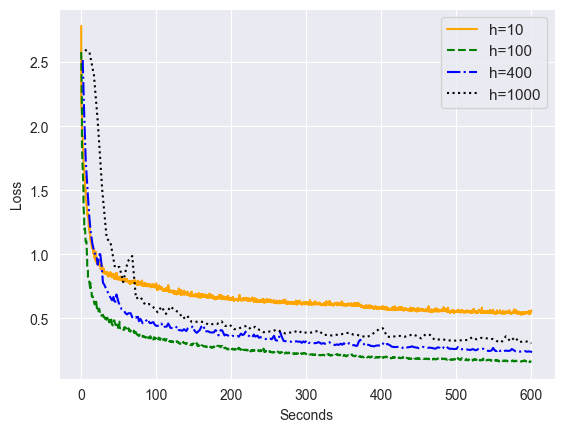

In [7]:
batch = 128
lr = 0.1
time_in_seconds = 60 * 10
configuration(n_hidden_nodes=10, batch_size=batch,
              lr=lr, time_in_seconds=time_in_seconds,
              label="h=10", color='orange', linestyle='-')
configuration(n_hidden_nodes=100, batch_size=batch,
              lr=lr, time_in_seconds=time_in_seconds,
              label="h=100", color='green', linestyle='--')
configuration(n_hidden_nodes=400, batch_size=batch,
              lr=lr, time_in_seconds=time_in_seconds,
              label="h=400", color='blue', linestyle='-.')
configuration(n_hidden_nodes=1000, batch_size=batch,
              lr=lr, time_in_seconds=time_in_seconds,
              label="h=1000", color='black', linestyle=':')
show_results()

Training: lr=0.001
  Loss: 0.96748983 (2 epochs completed, 992 total steps)
Training: lr=0.01
  Loss: 0.37424387 (2 epochs completed, 1003 total steps)
Training: lr=0.1
  Loss: 0.16900393 (2 epochs completed, 938 total steps)
Training: lr=1
  Loss: 0.70389083 (2 epochs completed, 962 total steps)


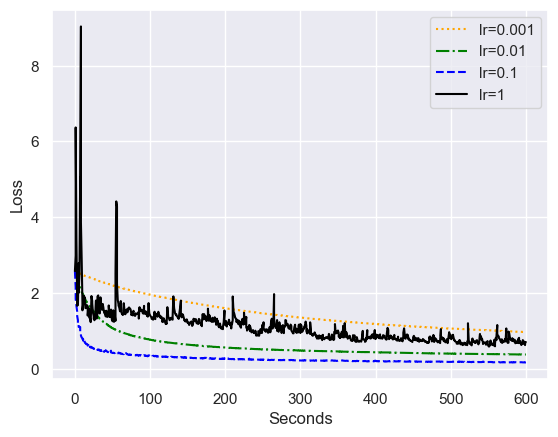

In [8]:
hidden = 100
batch = 128
time_in_seconds = 60 * 10
configuration(n_hidden_nodes=hidden, batch_size=batch,
              lr=0.001, time_in_seconds=time_in_seconds,
              label="lr=0.001", color='orange', linestyle=':')
configuration(n_hidden_nodes=hidden, batch_size=batch,
              lr=0.01, time_in_seconds=time_in_seconds,
              label="lr=0.01", color='green', linestyle='-.')
configuration(n_hidden_nodes=hidden, batch_size=batch,
              lr=0.1, time_in_seconds=time_in_seconds,
              label="lr=0.1", color='blue', linestyle='--')
configuration(n_hidden_nodes=hidden, batch_size=batch,
              lr=1, time_in_seconds=time_in_seconds,
              label="lr=1", color='black', linestyle='-')
show_results()

Training: batch_size=60000
  Loss: 0.32400252 (197 epochs completed, 197 total steps)
Training: batch_size=256
  Loss: 0.44940650 (1 epochs completed, 441 total steps)
Training: batch_size=128
  Loss: 1.06830331 (0 epochs completed, 465 total steps)
Training: batch_size=64
  Loss: 1.43040821 (0 epochs completed, 469 total steps)


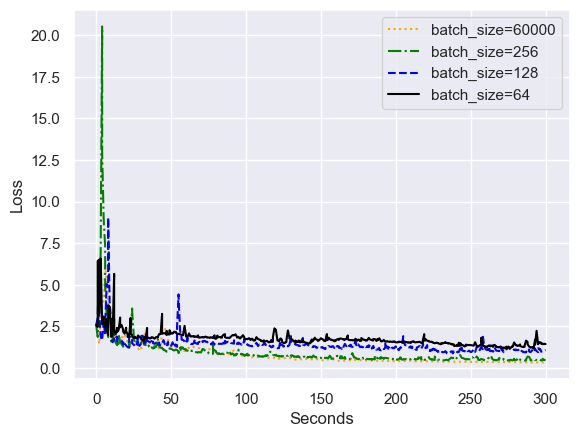

In [9]:
hidden = 100
lr = 1
time_in_seconds = 60 * 5
configuration(n_hidden_nodes=hidden, batch_size=60000,
              lr=lr, time_in_seconds=time_in_seconds,
              label="batch_size=60000", color='orange', linestyle=':')
configuration(n_hidden_nodes=hidden, batch_size=256,
              lr=lr, time_in_seconds=time_in_seconds,
              label="batch_size=256", color='green', linestyle='-.')
configuration(n_hidden_nodes=hidden, batch_size=128,
              lr=lr, time_in_seconds=time_in_seconds,
              label="batch_size=128", color='blue', linestyle='--')
configuration(n_hidden_nodes=hidden, batch_size=64,
              lr=lr, time_in_seconds=time_in_seconds,
              label="batch_size=64", color='black', linestyle='-')
show_results()

In [10]:
# Remove all the instrumentation from the train() function:

def train(X_train, Y_train, X_test, Y_test, n_hidden_nodes,
          epochs, batch_size, lr):
    n_input_variables = X_train.shape[1]
    n_classes = Y_train.shape[1]

    w1, w2 = initialize_weights(n_input_variables, n_hidden_nodes, n_classes)
    x_batches, y_batches = prepare_batches(X_train, Y_train, batch_size)
    for epoch in range(epochs):
        for batch in range(len(x_batches)):
            y_hat, h = forward(x_batches[batch], w1, w2)
            w1_gradient, w2_gradient = back(x_batches[batch], y_batches[batch],
                                            y_hat, w2, h)
            w1 = w1 - (w1_gradient * lr)
            w2 = w2 - (w2_gradient * lr)
            report(epoch, batch, X_train, Y_train, X_test, Y_test, w1, w2)
    return (w1, w2)

In [18]:
train(X_train, Y_train, X_test, Y_test,
      n_hidden_nodes=400, epochs=10, batch_size=256, lr=0.1)
print("Done.")

    0-0 > Loss: 1.99865678, Accuracy: 38.84%
    0-60 > Loss: 0.38281460, Accuracy: 92.10%
    0-120 > Loss: 0.32570945, Accuracy: 93.32%
    0-180 > Loss: 0.27399656, Accuracy: 94.58%
    1-0 > Loss: 0.25211627, Accuracy: 95.16%
    1-60 > Loss: 0.22066308, Accuracy: 95.86%
    1-120 > Loss: 0.20924883, Accuracy: 95.48%
    1-180 > Loss: 0.19056048, Accuracy: 96.40%
    2-0 > Loss: 0.18568697, Accuracy: 96.36%
    2-60 > Loss: 0.16788542, Accuracy: 96.70%
    2-120 > Loss: 0.15981978, Accuracy: 97.02%
    2-180 > Loss: 0.15098789, Accuracy: 96.88%
    3-0 > Loss: 0.14775160, Accuracy: 97.06%
    3-60 > Loss: 0.13746823, Accuracy: 97.20%
    3-120 > Loss: 0.13317495, Accuracy: 97.62%
    3-180 > Loss: 0.12683418, Accuracy: 97.56%
    4-0 > Loss: 0.12807986, Accuracy: 97.48%
    4-60 > Loss: 0.11848920, Accuracy: 97.62%
    4-120 > Loss: 0.11521709, Accuracy: 97.68%
    4-180 > Loss: 0.11036593, Accuracy: 97.64%
    5-0 > Loss: 0.11366502, Accuracy: 97.44%
    5-60 > Loss: 0.10415887, A